# Oscilador Armónico Amortiguado (Newton)

In [1]:
%reset -f

import sympy as smp
import numpy as np

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

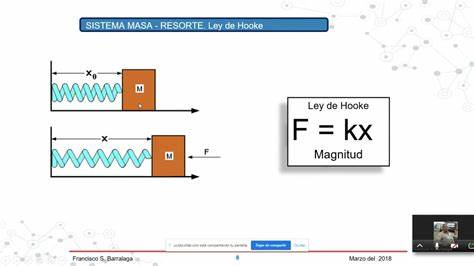

Define los simbolos apropiados en sympy

In [2]:
t, k, m, b = smp.symbols('t k m b', positive=True)

$$\vec{F} = m\vec{a}$$

Al estar al nivel del suelo solo hay una fuerza involucrada en el movimiento de la masa

$$F_{x} = ma_{x}$$

$x$ es una función dependiente del tiempo

In [3]:
x = smp.Function('x', real=True)
x = x(t)

Definimos las dos primeras derivadas temporales de $y$

In [4]:
d1_x = smp.diff(x, t)
d2_x = smp.diff(d1_x, t)

Asumimos que la fuerza de fricción depende linealmente de la velocidad <br>
$$F_r = b\dot{x}$$

In [5]:
Fr = b*d1_x
Fr

b*Derivative(x(t), t)

La fuerza del resorte ($kx$) y de fricción solo actúan a lo largo del eje $x$

In [6]:
Fx = -k*x - Fr
Fx

-b*Derivative(x(t), t) - k*x(t)

Se forma la ecuación de movimiento

In [7]:
Eq = smp.Eq(Fx, m*d2_x)
Eq

Eq(-b*Derivative(x(t), t) - k*x(t), m*Derivative(x(t), (t, 2)))

## Solución Exacta (dsolve)

In [8]:
Eq

Eq(-b*Derivative(x(t), t) - k*x(t), m*Derivative(x(t), (t, 2)))

In [9]:
x_explicit = smp.dsolve(Eq, x).args[1]
x_explicit

C1*exp(t*(-b + sqrt(b**2 - 4*k*m))/(2*m)) + C2*exp(-t*(b + sqrt(b**2 - 4*k*m))/(2*m))

Derivando dos veces la ecuación obtenida podemos obtener la velocidad y la aceleración

In [10]:
x_explicit.diff(t)

C1*(-b + sqrt(b**2 - 4*k*m))*exp(t*(-b + sqrt(b**2 - 4*k*m))/(2*m))/(2*m) - C2*(b + sqrt(b**2 - 4*k*m))*exp(-t*(b + sqrt(b**2 - 4*k*m))/(2*m))/(2*m)

In [11]:
x_explicit.diff(t, 2)

(C1*(b - sqrt(b**2 - 4*k*m))**2*exp(-t*(b - sqrt(b**2 - 4*k*m))/(2*m)) + C2*(b + sqrt(b**2 - 4*k*m))**2*exp(-t*(b + sqrt(b**2 - 4*k*m))/(2*m)))/(4*m**2)

## Solución Exacta con Condiciones Iniciales (dsolve)

In [12]:
Eq

Eq(-b*Derivative(x(t), t) - k*x(t), m*Derivative(x(t), (t, 2)))

Definimos las condiciones iniciales y resolvemos para $x$

In [13]:
t0 = 0
x0 = 10
vx0 = 0
S0 = {x.subs(t, t0):x0, d1_x.subs(t, t0):vx0}

In [14]:
x_explicit = smp.dsolve(Eq, x, ics=S0).args[1]
x_explicit

(-5*b/sqrt(b**2 - 4*k*m) + 5)*exp(-t*(b + sqrt(b**2 - 4*k*m))/(2*m)) + (5*b/sqrt(b**2 - 4*k*m) + 5)*exp(t*(-b + sqrt(b**2 - 4*k*m))/(2*m))

Derivando se puede obtener la velocidad y la aceleración

In [15]:
d1_x_explicit = smp.diff(x_explicit, t)
d1_x_explicit

(-b + sqrt(b**2 - 4*k*m))*(5*b/sqrt(b**2 - 4*k*m) + 5)*exp(t*(-b + sqrt(b**2 - 4*k*m))/(2*m))/(2*m) - (b + sqrt(b**2 - 4*k*m))*(-5*b/sqrt(b**2 - 4*k*m) + 5)*exp(-t*(b + sqrt(b**2 - 4*k*m))/(2*m))/(2*m)

Al haber un sobre-amortiguamiento se tiene que: <br>
$$b^2 > 4km$$ <br>
Al haber un sub-amortiguamiento se tiene que: <br>
$$b^2 < 4km$$ <br>
Al haber un amortiguamiento crítico se tiene que: <br>
$$b^2 = 4km$$

Definimos los valores de $m$, $b$ y $k$ y sustituimos en las ecuaciones obtenidas

Además, si se tiene que hay sub-amortiguamiento hay que tomar la parte real de la solución, ya que se va a generar una segunda componente imaginaria ($0i$)

In [16]:
x_explicit

(-5*b/sqrt(b**2 - 4*k*m) + 5)*exp(-t*(b + sqrt(b**2 - 4*k*m))/(2*m)) + (5*b/sqrt(b**2 - 4*k*m) + 5)*exp(t*(-b + sqrt(b**2 - 4*k*m))/(2*m))

In [17]:
mn = 2
kn = 2
bn = np.sqrt(4*kn*mn)

if bn**2 == 4*kn*mn:
    
    x_explicit = smp.limit(x_explicit, b, smp.sqrt(4*k*m), '+-')
    x_explicit = x_explicit.subs([
        [m, mn],
        [k, kn]
    ])
    
elif bn**2 > 4*kn*mn:
    
    x_explicit = x_explicit.subs([
        [m, mn],
        [k, kn],
        [b, bn]
    ])
    
elif bn**2 < 4*kn*mn:
    
    x_explicit = x_explicit.subs([
        [m, mn],
        [k, kn],
        [b, bn]
    ]).as_real_imag()[0]


In [18]:
x_explicit = x_explicit.simplify(force=True)
x_explicit

10*(t + 1)*exp(-t)

In [19]:
d1_x_explicit = smp.diff(x_explicit, t).simplify(force=True)
d1_x_explicit

-10*t*exp(-t)

La solución de la ecuación de movimiento (y la velocidad) es casi la misma que las anteriores, a esta se le definieron condiciones iniciales, ahora las transformamos en funciones de python-numpy con **lambdify**

In [20]:
x_exact = smp.lambdify((t), x_explicit, modules='numpy')
d1_x_exact = smp.lambdify((t), d1_x_explicit, modules='numpy')

Creamos un intervalo del tiempo en el que queremos evaluar la solución

In [21]:
t0 = 0
tf = 20*np.pi
t_size = 2001
t = np.linspace(t0, tf, t_size)

Evaluamos la velcidad y la posición

In [22]:
x_sol_exact = x_exact(t)
d1_x_sol_exact = d1_x_exact(t)

Graficamos

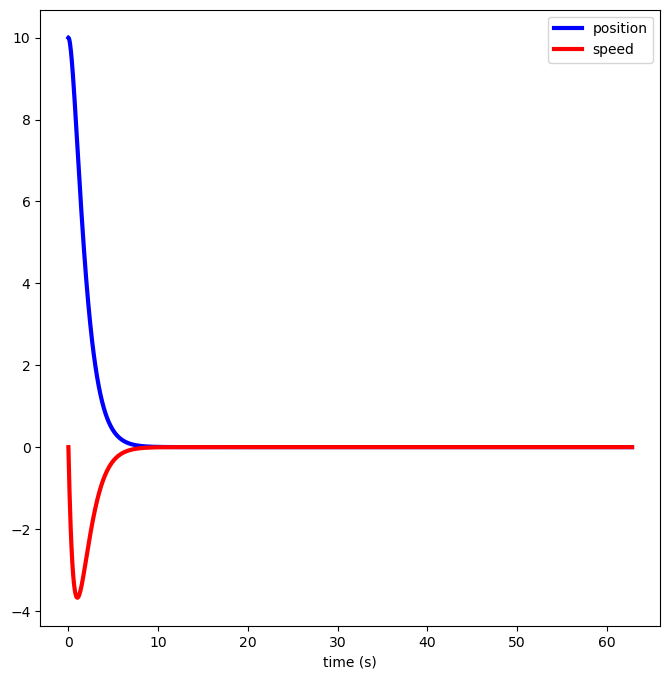

In [23]:
plt.figure(figsize=(8, 8))

plt.plot(t, x_sol_exact, lw=3, c='blue', label='position')
plt.plot(t, d1_x_sol_exact, lw=3, c='red', label='speed')

plt.xlabel('time (s)')
plt.legend()
plt.show()

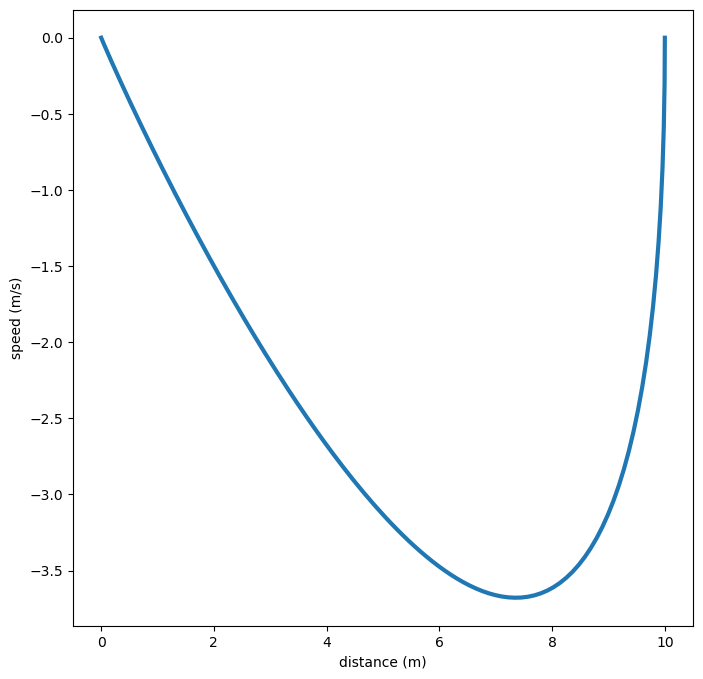

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(x_sol_exact, d1_x_sol_exact, lw=3)
plt.xlabel('distance (m)')
plt.ylabel('speed (m/s)')
plt.show()

## Solución Numerica

In [25]:
Eq

Eq(-b*Derivative(x(t), t) - k*x(t), m*Derivative(x(t), (t, 2)))

Volvemos a definir algunos simbolos ya que los habíamos sobre-escrito

In [26]:
t = smp.symbols('t', positive=True)

Despejamos la segunda derivada de $\ddot{x}$

In [27]:
d2_x_explicit = smp.solve([Eq], [d2_x])[d2_x]
d2_x_explicit

-b*Derivative(x(t), t)/m - k*x(t)/m

Para resolver numericamente la ecuación de segundo orden se tiene que transformar en un sistema de ecuaciones de primer orde, para eso realizamos la siguiente sustitución <br>
<ul>
  <li>$\dot{x} = z$</li>
  <li>$\dot{z} = \ddot{x} = ...$</li>
</ul> 
y este sistema lo transformamos en funciones númericas

In [28]:
dx_dt_f = smp.lambdify(d1_x, d1_x, modules='numpy')
dz_dt_f = smp.lambdify((t, k, m, b, x, d1_x), d2_x_explicit, modules='numpy')

Se define un vector $\vec{S} = (x, z)$ y una función que toma $\vec{S}$ y $t$, y devuelve $\dot{S}$ para poder resolver el sistema de ecuaciones

In [29]:
def dSdt(t, S, k, m, b):
    x, z = S
    return [
        dx_dt_f(z),
        dz_dt_f(t, k, m, b, x, z)
    ]

Definimos un arreglo de puntos en el tiempo en el cual queremos obtener la solución

In [30]:
t0 = 0
tf = 20*np.pi
t_size = 2001
t = np.linspace(t0, tf, t_size)

Se definen algunas constantes (constante del resorte y masa) que se guardan en la lista args y se definen las condiciones iniciales (posición:x0, velocidad: vx0) que se guardan en la lista S0

In [31]:
print('kn =', kn)
print('mn =', mn)
print('bn =', bn)

kn = 2
mn = 2
bn = 4.0


In [32]:
args = [kn, mn, bn]
x0 = 10
vx0 = 0
S0 = [x0, vx0]

Se utiliza la función solve_ivp para resolver la ecuación diferencial

In [33]:
sol = solve_ivp(dSdt, t_span=(t0, tf), y0=S0, method='RK45', t_eval=t, args=args)

Guardamos la solución y se grafica

In [34]:
x_sol_numeric = sol.y[0]
d1_x_sol_numeric = sol.y[1]

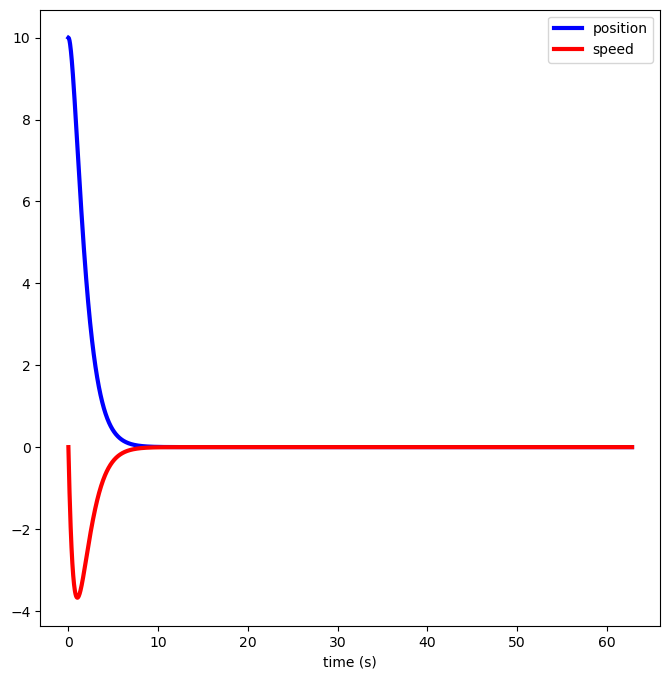

In [35]:
plt.figure(figsize=(8, 8))

plt.plot(t, x_sol_numeric, lw=3, c='blue', label='position')
plt.plot(t, d1_x_sol_numeric, lw=3, c='red', label='speed')

plt.xlabel('time (s)')
plt.legend()
plt.show()

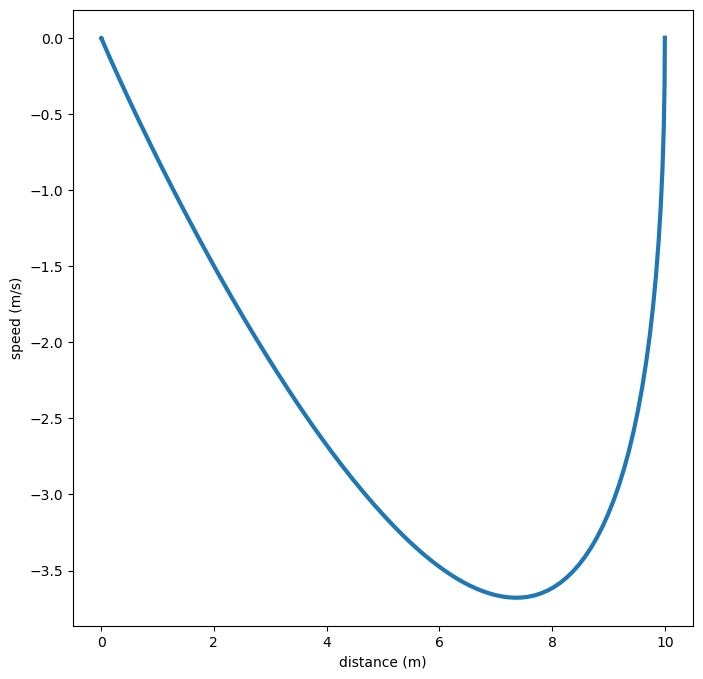

In [36]:
plt.figure(figsize=(8, 8))
plt.plot(x_sol_numeric, d1_x_sol_numeric, lw=3)
plt.xlabel('distance (m)')
plt.ylabel('speed (m/s)')
plt.show()

## Solución Exacta vs Numerica

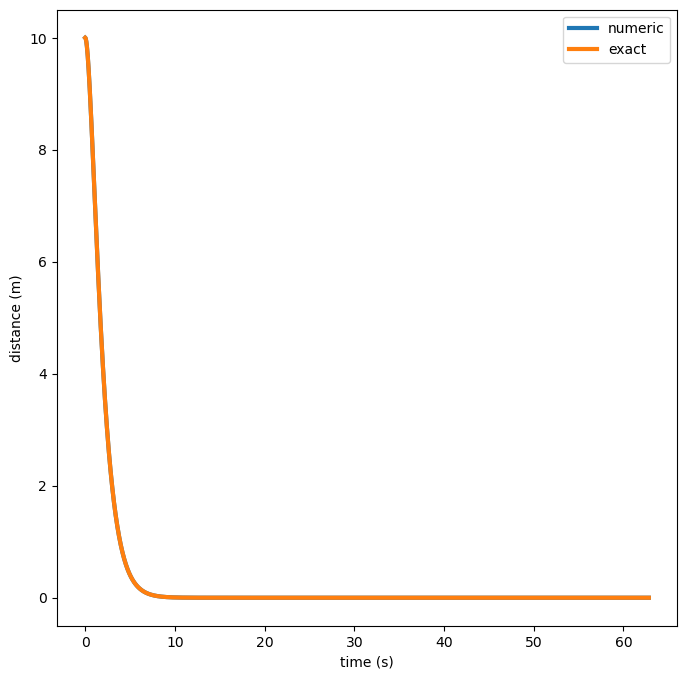

In [37]:
plt.figure(figsize=(8, 8))
plt.plot(t, x_sol_numeric, lw=3, label='numeric')
plt.plot(t, x_sol_exact, lw=3, label='exact')
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.legend()
plt.show()

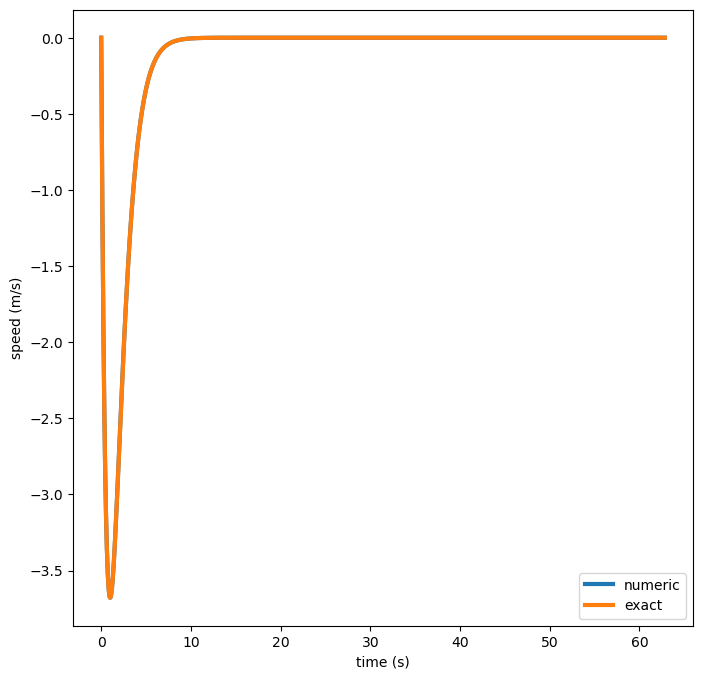

In [38]:
plt.figure(figsize=(8, 8))
plt.plot(t, d1_x_sol_numeric, lw=3, label='numeric')
plt.plot(t, d1_x_sol_exact, lw=3, label='exact')
plt.xlabel('time (s)')
plt.ylabel('speed (m/s)')
plt.legend()
plt.show()

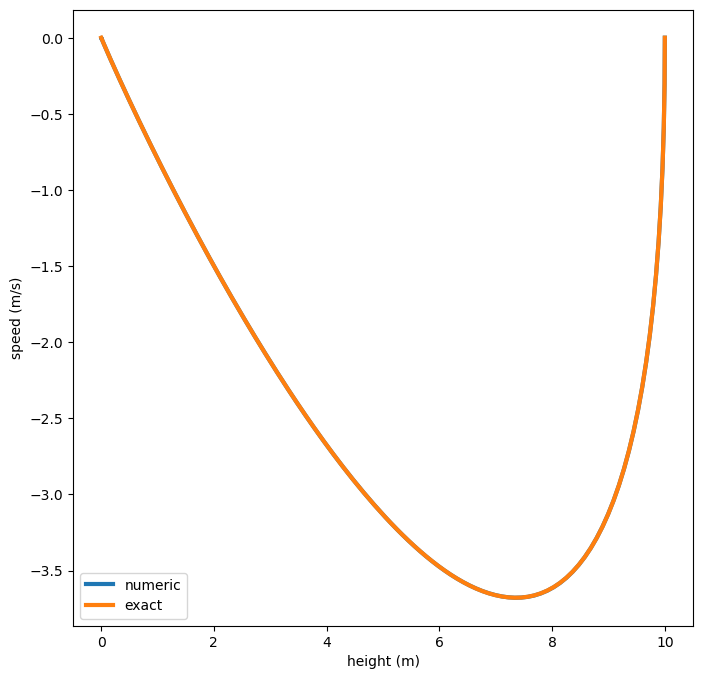

In [39]:
plt.figure(figsize=(8, 8))
plt.plot(x_sol_numeric, d1_x_sol_numeric, lw=3, label='numeric')
plt.plot(x_sol_exact, d1_x_sol_exact, lw=3, label='exact')
plt.xlabel('height (m)')
plt.ylabel('speed (m/s)')
plt.legend()
plt.show()

## Animación

In [40]:
fps = len(t[t<1])
frames = t_size - 1
interval = (tf/frames)*1000

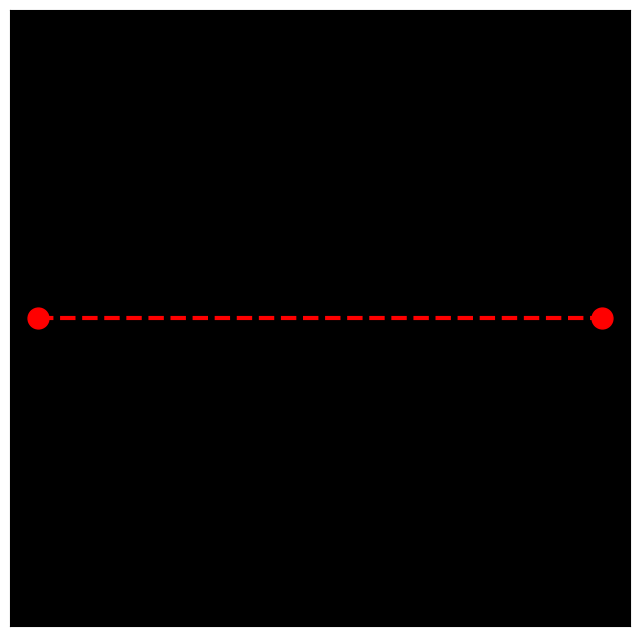

In [41]:
def animate(i):
    ln1.set_data([-x0, x_sol_numeric[i]], [0, 0])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ln1, = plt.plot([], [], 'ro--', lw=3, markersize=15)

ax.set_xlim(-x0-1, x0+1)
ax.set_ylim(-2, 2)

ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval)
ani.save('Animations/oscilador_armónico_amortiguado.mp4', writer='ffmpeg', fps=fps)